# 11 空間構造のある階層ベイズモデル

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributed
using Distributions
using ForneyLab
using LinearAlgebra
@everywhere using Mamba
using Plots
using SparseArrays
using Statistics
using StatsBase

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 11.1 例題 : 一次元空間上の個体数分布
### 例題の一次元空間上の架空データ

In [3]:
df = CSV.read("data/section11.csv")
disallowmissing!(df)

50×2 DataFrame
│ Row │ y     │ m       │
│     │ Int64 │ Float64 │
├─────┼───────┼─────────┤
│ 1   │ 0     │ 2.15498 │
│ 2   │ 3     │ 3.25417 │
│ 3   │ 2     │ 4.62867 │
│ 4   │ 5     │ 6.23412 │
│ 5   │ 6     │ 7.99073 │
│ 6   │ 16    │ 9.79447 │
│ 7   │ 8     │ 11.5334 │
│ 8   │ 14    │ 13.1043 │
│ 9   │ 11    │ 14.4263 │
│ 10  │ 10    │ 15.4488 │
⋮
│ 40  │ 17    │ 11.6433 │
│ 41  │ 8     │ 11.2182 │
│ 42  │ 7     │ 10.6165 │
│ 43  │ 10    │ 9.83561 │
│ 44  │ 4     │ 8.88885 │
│ 45  │ 5     │ 7.80682 │
│ 46  │ 5     │ 6.63673 │
│ 47  │ 7     │ 5.43822 │
│ 48  │ 4     │ 4.27619 │
│ 49  │ 3     │ 3.21171 │
│ 50  │ 1     │ 2.29286 │

横軸は調査区間の位置, 縦軸は観測された個体数, 破線はデータをポアソン乱数で生成するときに使った平均値

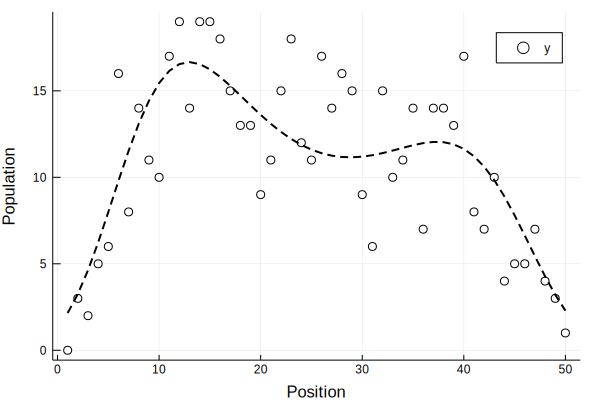

In [4]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = :white, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")

## 11.2 階層ベイズモデルに空間構造を組み込む
まず, 個体数$y_i$は, すべでの区画で共通する平均$\lambda$のポアソン分布に従うとしてみる.
\begin{align}
y_i & \sim \text{Poisson}(\lambda),\\
p(y_j \mid \lambda) & = \frac{\lambda^{y_i}\exp(-\lambda)}{y_j!}
\end{align}

このように仮定してすると, 平均$\lambda$と標本平均と等しいとしてみる.
### 標本平均

In [5]:
mean(df.y)

10.88

### 標本分散
ところが標本分散を求めてみると,

In [6]:
var(df.y)

27.373061224489796

となり, 標本平均の3倍近くなっている. そのため個体数が全ての区画で共通する平均$\lambda$のPoisson分布に従うと言う仮定は成立していなさそう.


そのため, 区間$j$ごとに平均$\lambda_i$が異なっているとし, 平均個体数を切片$\beta$と場所差$r_j$を用いて
\begin{align}
\log \lambda_i = \beta + r_j
\end{align}
と表す.
### 11.2.1. 空間構造のない階層事前分布
場所差$r_j$の事前分布を第10章で使ったような階層事前分布
\begin{align}
r_j & \sim \text{Normal}(0, s^2),\\
p(r_j \mid s) & = \frac{1}{\sqrt{2\pi s^2}}\exp \left( -\frac{r_j^2}{2s^2} \right)
\end{align}
であるとしてモデリングしてみる.

In [7]:
model1 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) ->
            UnivariateDistribution[
            Normal(0, s) for _ in 1:N
        ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [8]:
data1 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]

In [9]:
inits1 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.126756, 0.107845, 0.159248, -0.0274295, -0.0146281, 0.0347148, 0.0131143, 0.0100064, -0.0469851, -0.0379755  …  0.0935603, 0.0605788, 0.0775152, -0.0482113, 0.159815, -0.0170923, -0.0592873, -0.0678367, -0.0429682, 0.136421])     
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.149673, -0.0254793, 0.116637, -0.0468381, -0.0879199, 0.161067, -0.0575218, -0.0361021, -0.130057, -0.0789967  …  0.0475161, 0.121725, 0.0696122, -0.25335, -0.0850747, 0.238225, 0.0385961, 0.0142273, -0.0539945, 0.197489])        
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.213658, 0.0846791, 0.0138244, 0.0637651, 0.0201635, 0.0378714, -0.0387365, 0.0550774, -0.0907121, -0.000183963  …  -0.291471, -0.176089, -0.0871133, 0.0626189, -0.00547129, 0.00315931, 

In [10]:
scheme1 = [
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                    

In [11]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data1, inits1, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [9:43:18 of 9:43:24 remaining]
      From worker 4:	Chain 3:   0% [9:48:31 of 9:48:37 remaining]
      From worker 2:	Chain 1:   0% [9:41:12 of 9:41:17 remaining]
      From worker 3:	Chain 2:  10% [0:03:22 of 0:03:44 remaining]
      From worker 4:	Chain 3:  10% [0:03:21 of 0:03:44 remaining]
      From worker 2:	Chain 1:  10% [0:03:21 of 0:03:44 remaining]
      From worker 2:	Chain 1:  20% [0:02:34 of 0:03:13 remaining]
      From worker 4:	Chain 3:  20% [0:02:36 of 0:03:14 remaining]
      From worker 3:	Chain 2:  20% [0:02:37 of 0:03:16 remaining]
      From worker 2:	Chain 1:  30% [0:02:07 of 0:03:02 remaining]
      From worker 4:	Chain 3:  30% [0:02:08 of 0:03:03 remaining]
      From worker 3:	Chain 2:  30% [0:02:09 of 0:03:04 remaining]
      From worker 4:	Chain 3:  40% [0:01:46 of 0:02:57 remaining]
      From worker 2:	Chain 1:  40% [0:01:46 of 0:02:57 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.619141 2.2181 … 6.01046 5.00687; 0.376146 2.30236 … 9.05867 5.52218; … ; 0.4576 2.45455 … 6.08733 4.18763; 0.392871 2.35824 … 6.38783 7.27468]

[0.382262 2.26038 … 4.16672 3.52784; 0.396956 2.35483 … 6.08495 3.88378; … ; 0.40408 2.26329 … 3.62966 5.92794; 0.478845 2.40948 … 3.99153 3.87987]

[0.382432 2.30453 … 7.45248 2.36078; 0.363581 2.35488 … 6.03752 4.90874; … ; 0.380037 2.45247 … 11.1184 7.82476; 0.441306 2.37607 … 6.61653 3.82164]

In [12]:
describe(sim1)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD       Naive SE       MCSE      ESS
         s  0.45285577 0.082555079 0.0006740594 0.0009745540 5000
      beta  2.29721622 0.080951792 0.0006609686 0.0009059248 5000
 lambda[1]  4.41520596 1.618067800 0.0132114683 0.0157736965 5000
 lambda[2]  5.92436746 1.907698335 0.0155762917 0.0159767487 5000
 lambda[3]  5.38151015 1.794159237 0.0146492488 0.0167875600 5000
 lambda[4]  7.01049532 2.083312780 0.0170101776 0.0192959476 5000
 lambda[5]  7.59299397 2.202272853 0.0179814825 0.0186661300 5000
 lambda[6] 14.32903516 3.285894858 0.0268292192 0.0267704132 5000
 lambda[7]  8.80271455 2.379213050 0.0194261932 0.0208623077 5000
 lambda[8] 12.83607629 3.039023411 0.0248135222 0.0252437775 5000
 lambda[9] 10.81230443 2.690514340 0.0219679576 0.0215855546 5000
lambda[10] 10.09263086 2.606996797 0.0212860397 0.0203848723 5000
lambda[11] 15.02767509

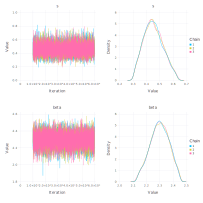

In [13]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:2], nrow = 2, ncol = 2)

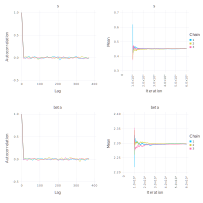

In [14]:
p2 = Mamba.plot(sim1, [:autocor, :mean], legend=true)
Mamba.draw(p2[:, 1:2], nrow = 2, ncol = 2)

$\lambda$の中央値、95%信頼区間をプロットしてみる

In [15]:
mre = quantile(sim1).value[3:end, :]

50×5 Array{Float64,2}:
  1.82552   3.22435   4.22845   5.40023   8.02407
  2.77978   4.5602    5.71751   7.07696  10.2441 
  2.43657   4.10192   5.18667   6.45577   9.43001
  3.55392   5.52162   6.80393   8.27764  11.7066 
  3.93919   6.02779   7.37155   8.91932  12.4651 
  8.70192  12.0228   14.0454   16.2932   21.6075 
  4.78246   7.09176   8.58695  10.2601   14.0682 
  7.74794  10.6675   12.5383   14.6732   19.5895 
  6.22336   8.89555  10.599    12.4553   16.7727 
  5.74185   8.24278   9.85839  11.6658   15.8995 
  9.27231  12.6073   14.7123   17.1157   22.5321 
 10.3587   13.9863   16.2036   18.7453   24.5204 
  7.63318  10.6515   12.5153   14.7324   19.7249 
  ⋮                                              
  7.19352  10.0061   11.8342   13.9012   18.6507 
  9.22135  12.5859   14.6912   17.1069   22.6266 
  4.81619   7.12828   8.63178  10.266    14.1475 
  4.40244   6.59787   7.97531   9.58774  13.2759 
  5.6879    8.22501   9.82249  11.6604   15.9063 
  3.18039   5.01176   6.245

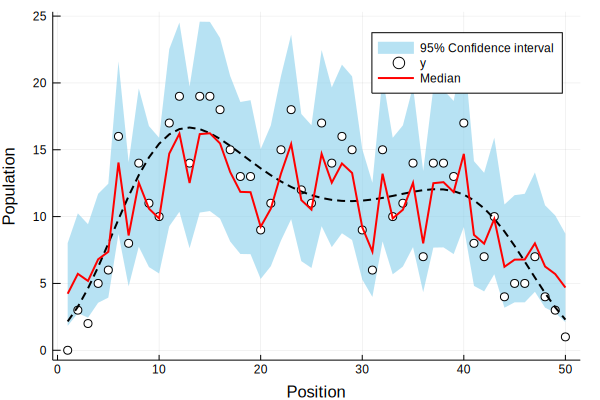

In [16]:
Plots.plot(1:50, mre[:, 1], lw = 0, 
    fillrange = mre[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = :white, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre[:, 3], linewidth = 2, linecolor = :red, label = "Median")

### 11.2.2 空間構造のある階層事前分布
ある区間はそれと隣接する区間とだけ相互作用すると仮定する. 
近傍数は$n_j = 2 \ (j \neq 1, 50), 1 \ (j = 1, 50)$となる.

\begin{align}
\mu_j & = \frac{r_{j-1} + r_{j+1}}{2}\ (j \neq 1, 50), \mu_1 = r_2, \mu_{50} = r_{49},\\
r_j \mid \mu_j, s & \sim \text{Normal}\left(\mu_j, \frac{s}{\sqrt{n_j}}\right)
\end{align}
と言うモデルを考える.
## 11.3 空間統計モデルをデータに当てはめる
CARモデルを実装する。
参考 : https://github.com/matsueushi/lip_stick_mamba

In [17]:
model2 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, alpha, N, D, adj) ->
            MvNormalCanon(zeros(N), 1 / (s * s) * (D - alpha * adj)),
        false
    ),
    
    alpha = Stochastic(() -> Uniform()),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [18]:
adj = spzeros(50, 50)
for i in 1:50-1
    adj[i, i+1] = 1
    adj[i+1, i] = 1
end
adj

50×50 SparseMatrixCSC{Float64,Int64} with 98 stored entries:
  [2 ,  1]  =  1.0
  [1 ,  2]  =  1.0
  [3 ,  2]  =  1.0
  [2 ,  3]  =  1.0
  [4 ,  3]  =  1.0
  [3 ,  4]  =  1.0
  [5 ,  4]  =  1.0
  [4 ,  5]  =  1.0
  [6 ,  5]  =  1.0
  [5 ,  6]  =  1.0
  [7 ,  6]  =  1.0
  [6 ,  7]  =  1.0
  ⋮
  [45, 44]  =  1.0
  [44, 45]  =  1.0
  [46, 45]  =  1.0
  [45, 46]  =  1.0
  [47, 46]  =  1.0
  [46, 47]  =  1.0
  [48, 47]  =  1.0
  [47, 48]  =  1.0
  [49, 48]  =  1.0
  [48, 49]  =  1.0
  [50, 49]  =  1.0
  [49, 50]  =  1.0

In [19]:
D = Diagonal(vec(sum(adj, dims=2)))

50×50 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    

In [20]:
data2 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
    :adj => adj,
    :D => D,
)

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => …
  :y   => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [21]:
inits2 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :alpha => 0.9,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.9,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.000404326, -0.0716873, 0.0586871, -0.0546035, -0.0309777, 0.114327, -0.0942397, -0.151338, -0.0299585, -0.0709957  …  0.0915155, -0.096131, 0.0424341, 0.0212877, -0.179592, 0.0029801, 0.0337598, 0.0538806, -0.182013, 0.0967222])
 Dict(:alpha=>0.9,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.0339219, 0.133409, 0.149605, -0.0229017, -0.0502398, 0.0121514, -0.0294688, 0.00721541, -0.0944724, -0.191512  …  -0.0041748, -0.0169013, 0.0609702, 0.0331057, -0.0594387, 0.262525, -0.0169924, 0.0186955, 0.0086431, -0.105922]) 
 Dict(:alpha=>0.9,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.10227, -0.0880377, -0.0534796, 0.0450192, 0.107494, 0.0553584, -0.0148089, -0.0402515, 0.0367241, -0.0973309  …  0.105304, 0.0534943, 0.0939453, 0.0700

In [22]:
scheme2 = [
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                    

In [23]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data2, inits2, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 4:	Chain 1:   0% [0:33:34 of 0:33:34 remaining]
      From worker 3:	Chain 2:   0% [0:33:59 of 0:33:59 remaining]
      From worker 2:	Chain 3:   0% [0:34:56 of 0:34:57 remaining]
      From worker 4:	Chain 1:  10% [0:03:49 of 0:04:15 remaining]
      From worker 2:	Chain 3:  10% [0:03:54 of 0:04:20 remaining]
      From worker 3:	Chain 2:  10% [0:03:56 of 0:04:22 remaining]
      From worker 4:	Chain 1:  20% [0:03:21 of 0:04:11 remaining]
      From worker 3:	Chain 2:  20% [0:03:24 of 0:04:14 remaining]
      From worker 2:	Chain 3:  20% [0:03:24 of 0:04:15 remaining]
      From worker 4:	Chain 1:  30% [0:02:56 of 0:04:12 remaining]
      From worker 2:	Chain 3:  30% [0:02:58 of 0:04:15 remaining]
      From worker 3:	Chain 2:  30% [0:02:59 of 0:04:15 remaining]
      From worker 4:	Chain 1:  40% [0:02:31 of 0:04:12 remaining]
      From worker 2:	Chain 3:  40% [0:02:32 of 0:04:14 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.335751 0.983542 … 3.25492 2.68951; 0.368339 0.968882 … 3.23528 3.53178; … ; 0.34138 0.993426 … 1.19691 1.29792; 0.348319 0.981022 … 1.64122 2.05649]

[0.436078 0.947426 … 4.22917 4.3134; 0.315881 0.993917 … 4.5769 4.99006; … ; 0.364378 0.977955 … 3.56691 2.64354; 0.314723 0.983583 … 2.72093 3.01159]

[0.320913 0.968139 … 3.36248 2.6359; 0.37391 0.870599 … 3.3596 3.35998; … ; 0.374213 0.986048 … 2.99575 1.67221; 0.43387 0.95492 … 2.43422 3.00945]

In [24]:
describe(sim2)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD        Naive SE       MCSE         ESS   
         s  0.28540131 0.070131971 0.00057262515 0.0011771950 3549.23932
     alpha  0.97636865 0.027603866 0.00022538462 0.0005849016 2227.27686
      beta  2.27711376 0.347674902 0.00283875369 0.0243796455  203.37235
 lambda[1]  2.84835108 1.081499978 0.00883041034 0.0148620375 5000.00000
 lambda[2]  3.41227189 1.074328802 0.00877185793 0.0158714572 4581.84964
 lambda[3]  4.03375739 1.119741425 0.00914265045 0.0174703529 4108.01610
 lambda[4]  5.38715703 1.324575600 0.01081511448 0.0172108065 5000.00000
 lambda[5]  7.21213082 1.611682744 0.01315933450 0.0174141141 5000.00000
 lambda[6] 10.65637418 2.262511977 0.01847333293 0.0228480835 5000.00000
 lambda[7] 10.16990672 2.032981483 0.01659922430 0.0204573971 5000.00000
 lambda[8] 11.84038016 2.311180989 0.01887071376 0.0224157830 5000.00000
 lam

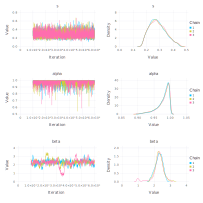

In [25]:
p3 = Mamba.plot(sim2, legend = true)
Mamba.draw(p3[:, 1:3], nrow = 3, ncol = 2)

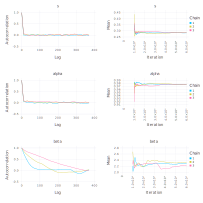

In [26]:
p4 = Mamba.plot(sim2, [:autocor, :mean], legend=true)
Mamba.draw(p4[:, 1:3], nrow = 3, ncol = 2)

In [27]:
mre2 = quantile(sim2).value[4:end, :]

50×5 Array{Float64,2}:
  1.1213    2.06043   2.72001   3.49228   5.31698
  1.61546   2.64441   3.30916   4.07319   5.7985 
  2.09577   3.22323   3.94085   4.73485   6.47122
  3.11853   4.44867   5.28241   6.20996   8.29066
  4.47661   6.08904   7.05947   8.15674  10.7653 
  6.9416    9.04146  10.4081   11.9892   15.8158 
  6.62854   8.76903  10.0148   11.4069   14.6318 
  7.9761   10.2166   11.6268   13.2268   16.9704 
  7.77467  10.0826   11.4776   13.0177   16.4181 
  8.07843  10.5406   12.0044   13.6037   17.1445 
 10.4346   13.289    14.9407   16.8495   21.0067 
 11.7242   14.72     16.5046   18.5754   23.2815 
 10.8418   13.8567   15.5859   17.5508   21.621  
  ⋮                                              
  8.77314  11.2869   12.7684   14.4626   18.3026 
  8.80851  11.2646   12.798    14.6356   18.8481 
  6.32454   8.3444    9.56087  10.8843   13.9314 
  5.28341   7.08793   8.19981   9.4303   12.1684 
  5.04359   6.72141   7.75955   8.96491  11.8472 
  3.78069   5.23823   6.112

### Plotting

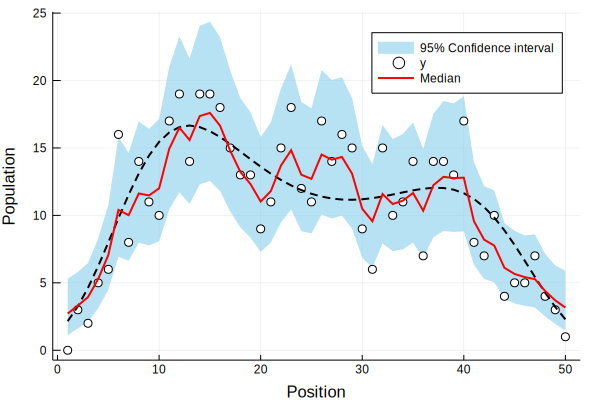

In [28]:
Plots.plot(1:50, mre2[:, 1], lw = 0, 
    fillrange = mre2[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = :white, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre2[:, 3], linewidth = 2, linecolor = :red, label = "Median")

## 11.5 空間相関モデルと欠測のある観測データ
Missing Values Sampler  
https://mambajl.readthedocs.io/en/latest/samplers/miss.html  
を使って、欠測のある観測データを使った予測を行う。
### まずは、空間相関のないモデル

In [29]:
y_missing = convert(Vector{Union{Missing, Float64}}, df.y)
missing_place = [6, 9, 12, 13, 26, 27, 28, 29, 30]
y_missing[missing_place] .= NaN

9-element view(::Array{Union{Missing, Float64},1}, [6, 9, 12, 13, 26, 27, 28, 29, 30]) with eltype Union{Missing, Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [30]:
y_missing

50-element Array{Union{Missing, Float64},1}:
   0.0
   3.0
   2.0
   5.0
   6.0
 NaN  
   8.0
  14.0
 NaN  
  10.0
  17.0
 NaN  
 NaN  
   ⋮  
  13.0
  17.0
   8.0
   7.0
  10.0
   4.0
   5.0
   5.0
   7.0
   4.0
   3.0
   1.0

In [31]:
data1_missing = Dict{Symbol, Any}(
    :y => y_missing,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 1…

In [32]:
inits1_missing = [
    Dict{Symbol, Any}(
        :y => y_missing,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[-0.0723364, -0.0409773, 0.106825, -0.0705702, 0.0512184, 0.065629, 0.00898084, -0.0454213, -0.0546851, 0.0226318  …  -0.0536697, 0.0316093, -0.0876997, 0.0207114, 0.0344547, 0.049126, 0.128612, -0.132573, -0.0810784, -0.0242869])
 Dict(:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[0.216041, 0.0851051, 0.0361093, -0.0106433, -0.075447, -0.00921344, -0.0620276, 0.0370317, -0.18104, 0.151253  …  0.155305, -0.0230545, -0.0679663, 0.157227, 0.230806, -0.0389405, -0.137272, -0.253555, -0.172014, 0.137751])      
 Dict(:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[0.0306375, 

In [33]:
scheme1_missing = [
    MISS(:y),
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Dict{Symbol,Mamba.MISSTune}}"
Sampling Block Nodes:
Symbol[:y]

CodeInfo(
1 ─ %1 = π (##262#263(Box(Symbol[:y])), Const(##262#263(Box(Symbol[:y])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                                                                     
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──    

In [34]:
setsamplers!(model1, scheme1_missing)
sim1_missing = mcmc(model1, data1_missing, inits1_missing, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [1:42:29 of 1:42:30 remaining]
      From worker 2:	Chain 3:   0% [1:43:49 of 1:43:50 remaining]
      From worker 4:	Chain 1:   0% [1:51:12 of 1:51:13 remaining]
      From worker 4:	Chain 1:  10% [0:02:33 of 0:02:50 remaining]
      From worker 3:	Chain 2:  10% [0:02:34 of 0:02:51 remaining]
      From worker 2:	Chain 3:  10% [0:02:37 of 0:02:55 remaining]
      From worker 3:	Chain 2:  20% [0:02:13 of 0:02:46 remaining]
      From worker 4:	Chain 1:  20% [0:02:13 of 0:02:47 remaining]
      From worker 2:	Chain 3:  20% [0:02:15 of 0:02:48 remaining]
      From worker 4:	Chain 1:  30% [0:01:55 of 0:02:44 remaining]
      From worker 3:	Chain 2:  30% [0:01:56 of 0:02:45 remaining]
      From worker 2:	Chain 3:  30% [0:01:56 of 0:02:45 remaining]
      From worker 4:	Chain 1:  40% [0:01:38 of 0:02:43 remaining]
      From worker 3:	Chain 2:  40% [0:01:39 of 0:02:44 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.411462 2.12639 … 4.22452 3.77195; 0.478768 2.1343 … 4.68943 4.78278; … ; 0.456116 2.16946 … 6.04273 3.21356; 0.480363 2.16811 … 4.21392 2.29254]

[0.418409 2.28443 … 5.00322 4.76572; 0.500863 2.07845 … 5.64924 4.77395; … ; 0.394146 2.27169 … 6.8638 4.17475; 0.468492 2.28649 … 6.41034 2.96298]

[0.51916 2.21342 … 7.21059 2.34086; 0.429945 2.3931 … 5.30065 3.93801; … ; 0.590842 2.02152 … 6.09271 2.59572; 0.399636 2.09206 … 3.92231 4.92421]

In [35]:
describe(sim1_missing)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean        SD        Naive SE       MCSE        ESS   
         s  0.50995856 0.09819568 0.00080176439 0.0013854078 5000.0000
      beta  2.19781026 0.09909927 0.00080914212 0.0014103640 4937.1740
 lambda[1]  3.78733055 1.53619485 0.01254297845 0.0153201562 5000.0000
 lambda[2]  5.33535826 1.80807584 0.01476287738 0.0176761971 5000.0000
 lambda[3]  4.79983224 1.75348670 0.01431715892 0.0171141490 5000.0000
 lambda[4]  6.52644954 2.01308545 0.01643677390 0.0177310931 5000.0000
 lambda[5]  7.16599190 2.18760122 0.01786168918 0.0177740710 5000.0000
 lambda[6] 10.29376013 6.00787213 0.04905407050 0.0880735023 4653.1904
 lambda[7]  8.43383296 2.39155433 0.01952695935 0.0184763997 5000.0000
 lambda[8] 12.72054939 3.15607707 0.02576926135 0.0284768508 5000.0000
 lambda[9] 10.24683028 5.77152307 0.04712428854 0.0769603177 5000.0000
lambda[10]  9.86205218 2.677

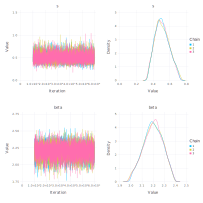

In [36]:
p5 = Mamba.plot(sim1_missing, legend = true)
Mamba.draw(p5[:, 1:2], nrow = 2, ncol = 2)

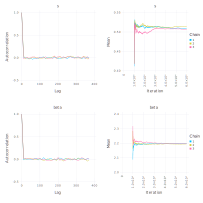

In [37]:
p6 = Mamba.plot(sim1_missing, [:autocor, :mean], legend=true)
Mamba.draw(p6[:, 1:2], nrow = 2, ncol = 2)

### 次に、空間相関のあるモデル

In [38]:
data2_missing = Dict{Symbol, Any}(
    :y => y_missing,
    :N => length(df.y),
    :adj => adj,
    :D => D,
)

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => …
  :y   => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN,…
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [39]:
inits2_missing = [
    Dict{Symbol, Any}(
        :y => y_missing,
        :alpha => 0.9,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.9,:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[-0.139635, 0.093308, -0.037106, -0.0886197, -0.0663959, 0.0147376, 0.0237684, -0.0122006, -0.127898, -0.101003  …  -0.0174702, -0.0410273, 0.11183, -0.0176716, 0.0419645, -0.0157149, -0.0772012, -0.116768, 0.0532812, 0.0714198]) 
 Dict(:alpha=>0.9,:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[0.0206527, 0.102665, 0.0323029, 0.0182205, -0.0720278, -0.0157073, -0.0234775, 0.0104073, 0.0456421, 0.0216601  …  -0.0121324, -0.0170092, 0.0485727, -0.0271258, 0.00607607, -0.167754, 0.0158576, -0.0306876, 0.254679, 0.0726676])
 Dict(:alpha=>0.9,:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0

In [40]:
scheme2_missing = [
    MISS(:y),
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Dict{Symbol,Mamba.MISSTune}}"
Sampling Block Nodes:
Symbol[:y]

CodeInfo(
1 ─ %1 = π (##262#263(Box(Symbol[:y])), Const(##262#263(Box(Symbol[:y])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                                                                     
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──    

In [41]:
setsamplers!(model2, scheme2_missing)
sim2_missing = mcmc(model2, data2_missing, inits2_missing, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 2:	Chain 3:   0% [0:06:13 of 0:06:13 remaining]
      From worker 4:	Chain 1:   0% [0:06:42 of 0:06:42 remaining]
      From worker 3:	Chain 2:   0% [0:08:01 of 0:08:01 remaining]
      From worker 2:	Chain 3:  10% [0:03:41 of 0:04:05 remaining]
      From worker 4:	Chain 1:  10% [0:03:44 of 0:04:09 remaining]
      From worker 3:	Chain 2:  10% [0:03:50 of 0:04:15 remaining]
      From worker 4:	Chain 1:  20% [0:03:21 of 0:04:11 remaining]
      From worker 2:	Chain 3:  20% [0:03:22 of 0:04:12 remaining]
      From worker 3:	Chain 2:  20% [0:03:27 of 0:04:19 remaining]
      From worker 4:	Chain 1:  30% [0:02:54 of 0:04:09 remaining]
      From worker 2:	Chain 3:  30% [0:02:55 of 0:04:10 remaining]
      From worker 3:	Chain 2:  30% [0:02:58 of 0:04:14 remaining]
      From worker 2:	Chain 3:  40% [0:02:29 of 0:04:08 remaining]
      From worker 4:	Chain 1:  40% [0:02:29 of 0:04:09 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.244384 0.977985 … 3.58009 2.65674; 0.272909 0.991335 … 4.16685 2.98887; … ; 0.369717 0.924618 … 4.85086 5.24333; 0.460579 0.961748 … 6.46917 4.20605]

[0.296875 0.984941 … 3.32498 2.20235; 0.320321 0.962792 … 3.81546 5.31895; … ; 0.281676 0.977417 … 5.89987 6.69979; 0.218428 0.97638 … 3.43324 4.19806]

[0.438806 0.981658 … 2.13427 2.00556; 0.431644 0.972247 … 4.55926 4.22989; … ; 0.216768 0.988245 … 3.62475 3.37143; 0.312328 0.990092 … 2.899 2.95198]

In [48]:
describe(sim2_missing)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean        SD        Naive SE        MCSE         ESS   
         s  0.30895038 0.08006999 0.00065376873 0.00130886882 3742.37497
     alpha  0.97205360 0.03286034 0.00026830355 0.00067778427 2350.50477
      beta  2.25273451 0.31531177 0.00257450981 0.02054233888  235.60287
 lambda[1]  2.61895210 1.03445677 0.00844630414 0.01385612868 5000.00000
 lambda[2]  3.17358740 1.02668424 0.00838284175 0.01517338228 4578.35005
 lambda[3]  3.69778384 1.07840363 0.00880512873 0.01446306519 5000.00000
 lambda[4]  4.83301261 1.27661472 0.01042351554 0.01570978295 5000.00000
 lambda[5]  5.99486012 1.54338448 0.01260168150 0.02000903270 5000.00000
 lambda[6]  7.38543744 2.27579491 0.01858178766 0.02815588854 5000.00000
 lambda[7]  8.72343036 1.98219399 0.01618454612 0.02161900224 5000.00000
 lambda[8] 11.29882330 2.45369237 0.02003431427 0.02741936350 5000.00000
 lam

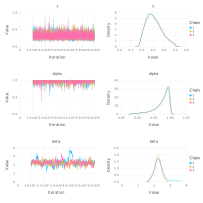

In [42]:
p7 = Mamba.plot(sim2_missing, legend = true)
Mamba.draw(p7[:, 1:3], nrow = 3, ncol = 2)

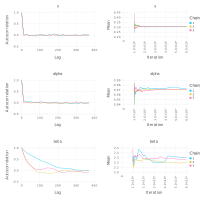

In [43]:
p8 = Mamba.plot(sim2_missing, [:autocor, :mean], legend=true)
Mamba.draw(p8[:, 1:3], nrow = 3, ncol = 2)

### モデルの比較
空間相関のあるモデル・ないモデルを比較する。

In [44]:
scatter_color = fill(:white, 50)
scatter_color[missing_place] .= :black

9-element view(::Array{Symbol,1}, [6, 9, 12, 13, 26, 27, 28, 29, 30]) with eltype Symbol:
 :black
 :black
 :black
 :black
 :black
 :black
 :black
 :black
 :black

In [45]:
vsspan_x = collect(Iterators.flatten(zip(missing_place .- 0.5, missing_place .+ 0.5)))

18-element Array{Float64,1}:
  5.5
  6.5
  8.5
  9.5
 11.5
 12.5
 12.5
 13.5
 25.5
 26.5
 26.5
 27.5
 27.5
 28.5
 28.5
 29.5
 29.5
 30.5

空間相関を考慮していないモデル

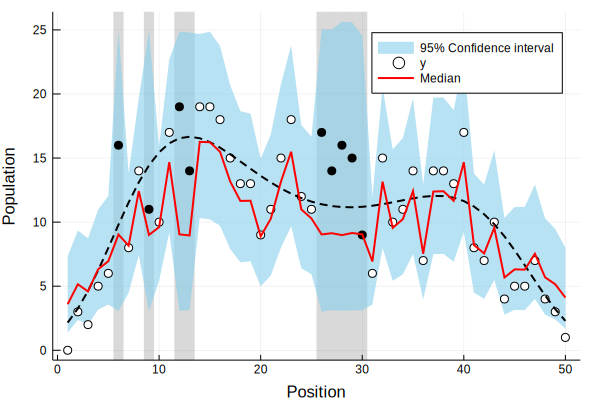

In [46]:
mre3 = quantile(sim1_missing).value[3:end, :]
vspan(vsspan_x, fillcolor = :black, linecolor =:transparent, fillalpha = 0.15, label = "")
plot!(1:50, mre3[:, 1], lw = 0, 
    fillrange = mre3[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = scatter_color, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre3[:, 3], linewidth = 2, linecolor = :red, label = "Median")

空間相関を考慮しているモデル

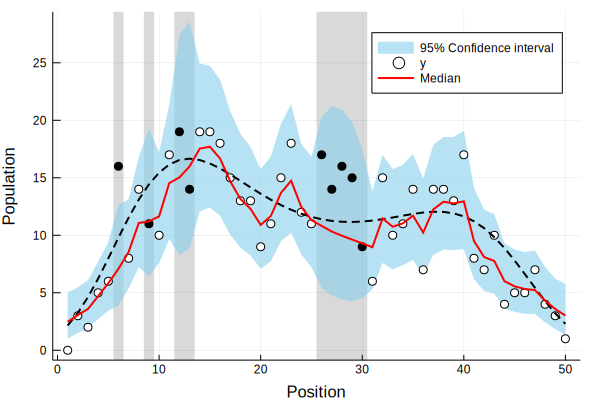

In [47]:
mre4 = quantile(sim2_missing).value[4:end, :]
vspan(vsspan_x, fillcolor = :black, linecolor =:transparent, fillalpha = 0.15, label = "")
plot!(1:50, mre4[:, 1], lw = 0, 
    fillrange = mre4[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = scatter_color, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre4[:, 3], linewidth = 2, linecolor = :red, label = "Median")

空間相関を考慮すると、欠測データに対し隣同士の相互作用を用いた予測ができるため、相関を考慮しないものに比べて予測区間の幅が小さくなる